“NO2 data used in this presentation were produced with the Giovanni online data system, developed and maintained by the NASA GES DISC."

![Questions](images/question12.png "Questions")

## COLLECT VARIOUS DATA IN TO A SINGLE TABLE

In [12]:
#Importing the relevant libraries

import requests
from lxml import html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import emoji
%matplotlib inline

## 1. add covid-mortalities per municipality

read in the RIVM data

In [13]:
rf = pd.read_csv('COVID-19_aantallen_gemeente_cumulatief.csv',sep = ';')
# exclude province-summary rows (non-municipal rows)
rf=rf[rf['Municipality_code'].notna()]

In [14]:
rf

Date_of_report Municipality_code  Municipality_name  \
0       2020-03-13 10:00:00            GM0003         Appingedam   
1       2020-03-13 10:00:00            GM0010           Delfzijl   
2       2020-03-13 10:00:00            GM0014          Groningen   
3       2020-03-13 10:00:00            GM0024          Loppersum   
4       2020-03-13 10:00:00            GM0034             Almere   
...                     ...               ...                ...   
156675  2021-05-14 10:00:00            GM1966       Het Hogeland   
156676  2021-05-14 10:00:00            GM1969     Westerkwartier   
156677  2021-05-14 10:00:00            GM1970  Noardeast-Fryslân   
156678  2021-05-14 10:00:00            GM1978        Molenlanden   
156679  2021-05-14 10:00:00            GM1979          Eemsdelta   

            Province  Total_reported  Hospital_admission  Deceased  
0          Groningen               0                   0         0  
1          Groningen               0                   0         0  
2          Groningen               3                   0         0  
3          Groningen               0                   0         0  
4          Flevoland               1                   1         0  
...              ...             ...                 ...       ...  
156675     Groningen            3309                  30        20  
156676     Groningen            3142                  36        24  
156677       Fryslân            3085                  43        37  
156678  Zuid-Holland            5423                  49        34  
156679     Groningen            2745                  45        20  

[151556 rows x 7 columns]

list of unique municipalities

In [15]:
municipalities = list(set(rf['Municipality_name']))

CBS: Hengelo O  
RIVM: Hengelo (O.)

Better fix this...🤔

In [16]:
# edit the municipality names
def clean(string):
    string = string.replace('(','')
    string = string.replace(')','')
    string = string.replace('.','')
    return string

rf['Municipality_name'] = rf['Municipality_name'].apply(lambda x: clean(x))
municipalities = list(set(rf['Municipality_name']))

### check how the data is organized per municipality

In [17]:
pos=municipalities.index('Eindhoven')

In [18]:
# take a sum of differences, because data is cumulative
rf[rf['Municipality_name']==municipalities[pos]][['Municipality_name','Date_of_report','Deceased','Total_reported','Hospital_admission']][20:30]

Municipality_name       Date_of_report  Deceased  Total_reported  \
7552          Eindhoven  2020-04-02 10:00:00        17             192   
7919          Eindhoven  2020-04-03 10:00:00        20             201   
8286          Eindhoven  2020-04-04 10:00:00        20             202   
8653          Eindhoven  2020-04-05 10:00:00        22             213   
9020          Eindhoven  2020-04-06 10:00:00        24             221   
9387          Eindhoven  2020-04-07 10:00:00        30             238   
9754          Eindhoven  2020-04-08 10:00:00        32             253   
10121         Eindhoven  2020-04-09 10:00:00        34             256   
10488         Eindhoven  2020-04-10 10:00:00        36             273   
10855         Eindhoven  2020-04-11 10:00:00        36             279   

       Hospital_admission  
7552                   71  
7919                   81  
8286                   89  
8653                   88  
9020                   88  
9387                   93  
9754                   94  
10121                  95  
10488                 102  
10855                 111

In [19]:
deceased = []
for municipality in municipalities:
    total = rf[rf['Municipality_name']==municipality]['Deceased'].diff().fillna(0).sum()
    deceased.append(total)
#     print('total deceased in '+municipality+': '+str(np.round(total)))
infected = []
for municipality in municipalities:
    total = rf[rf['Municipality_name']==municipality]['Total_reported'].diff().fillna(0).sum()
    infected.append(total)
hospitalized = []
for municipality in municipalities:
    total = rf[rf['Municipality_name']==municipality]['Hospital_admission'].diff().fillna(0).sum()
    hospitalized.append(total)

put the number of total deceased per municipality in dataframe

In [20]:
# new dataframe
df = pd.DataFrame(columns = ['Municipality','Deceased'])
df['Municipality'] = municipalities
df['Deceased'] = deceased
df['infected'] = infected
df['hospitalized'] = hospitalized

In [21]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized
338     's-Gravenhage     548.0   51152.0        1586.0
191  's-Hertogenbosch     167.0   15976.0         248.0
266       Aa en Hunze      20.0    1331.0           7.0
126          Aalsmeer      26.0    2964.0          36.0
71             Aalten      21.0    2342.0          29.0

## 2. add NO2 data

In [22]:
no2 = pd.read_excel('RIVM_CBS_NO2_2021.xlsx')
no2 = no2[['Municipality','NO2']]

In [23]:
df=pd.merge(df, no2, on='Municipality', how="left") #Left join

In [26]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized       NO2
338     's-Gravenhage     548.0   51152.0        1586.0  0.875470
191  's-Hertogenbosch     167.0   15976.0         248.0  0.875519
266       Aa en Hunze      20.0    1331.0           7.0  0.607668
126          Aalsmeer      26.0    2964.0          36.0  0.824251
71             Aalten      21.0    2342.0          29.0  0.812852

## 3. add relative number of elderly people per municipality (CBS) 👴👵

In [27]:
ld = pd.read_excel('olderthan75.xlsx')

In [28]:
ld=ld.rename(columns={'Regio\'s':'Municipality'})

In [29]:
# different age bins
ld=ld[['Municipality', '7580', '8085', '8590', '9095','95']]

In [30]:
total = ld[ld.columns[1:]].sum(axis = 1)

In [31]:
ld.loc[:,'seniors'] = total

In [32]:
df=pd.merge(df, ld, on='Municipality', how="left") #Left join

In [33]:
df.columns

Index(['Municipality', 'Deceased', 'infected', 'hospitalized', 'NO2', '7580',
       '8085', '8590', '9095', '95', 'seniors'],
      dtype='object')

In [34]:
df = df[['Municipality',  'Deceased','infected', 'hospitalized',  'seniors','NO2']]

In [35]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852

In [36]:
len(df)

357

## 4. add total populations per municipality

In [38]:
ld = pd.read_csv('Regionale_kerncijfers.csv',sep=';')

In [39]:
ld.head()

Perioden      Regio's  \
0      2020  Aa en Hunze   
1      2020      Aalburg   
2      2020     Aalsmeer   
3      2020       Aalten   
4      2020      Ter Aar   

   Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)  
0                                            25445.0                         
1                                                NaN                         
2                                            31859.0                         
3                                            27121.0                         
4                                                NaN

In [40]:
ld=ld.rename(columns={ld.columns[2]:'Population','Regio\'s':'Municipality'})

In [41]:
ld=ld.fillna(0)

In [42]:
ld=ld[ld.columns[1:]]

In [43]:
# edit incompatible municipality names
ld.loc[:,'Municipality'] = ld['Municipality'].apply(lambda x: x.split('(')[0].strip())
ld.loc[:,'Municipality'] = ld['Municipality'].apply(lambda x:x.replace(' (gemeente)',''))
ld = ld.drop_duplicates(subset='Municipality', keep="last")

In [44]:
df=pd.merge(df, ld, on='Municipality', how="left") #Left join

In [45]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2  \
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470   
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519   
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668   
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251   
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852   

     Population  
338    545838.0  
191    155111.0  
266     25445.0  
126     31859.0  
71      27121.0

## 5.  add agricultural-data 🐖🐄🐔

In [47]:
ld=pd.read_csv('Landbouw__gewassen__dieren_en_grondgebruik_naar_gemeente_02072020_185801.csv',sep = ';')

In [48]:
ld.head()

Unnamed: 0  Aa en Hunze  Aalburg  Aalsmeer  Aalten  Ter Aar  \
0            Rundvee        13723      NaN        52   15506      NaN   
1            Schapen         3242      NaN        84    1774      NaN   
2             Geiten          128      NaN         6      69      NaN   
3  Paarden en pony's          867      NaN        13     227      NaN   
4            Varkens            0      NaN         2   81861      NaN   

   Abcoude  Achtkarspelen  Akersloot  Alblasserdam  ...  Zoetermeer  \
0      NaN          13617        NaN           229  ...         968   
1      NaN          11327        NaN            56  ...        1770   
2      NaN             69        NaN             0  ...          32   
3      NaN            380        NaN            51  ...          78   
4      NaN          18744        NaN          1145  ...           0   

   Zoeterwoude  Zuidhorn  Zuidplas  Zundert  Zutphen  Zwartewaterland  \
0         3569       NaN      2036    15695     2958            17668   
1         3192       NaN      2938      100      652             3297   
2          296       NaN        37     1083        8             1422   
3           36       NaN       175      306      204              185   
4          264       NaN      1142    45615     1610                3   

   Zwartsluis  Zwijndrecht  Zwolle  
0         NaN          125   10955  
1         NaN          219    1852  
2         NaN            8      52  
3         NaN           61     216  
4         NaN            0   37935  

[5 rows x 601 columns]

In [49]:
# transpose and clean up
ld=ld.T
ld.rename(columns=ld.iloc[0],inplace = True)
ld=ld[1:]
ld['Municipality']=ld.index

In [50]:
ld.filter(like='Graven',axis=0)

Rundvee Schapen Geiten Paarden en pony's Varkens  \
's-Gravendeel                NaN     NaN    NaN               NaN     NaN   
's-Gravenhage (gemeente)      63     701      9                 7       0   
's-Gravenzande               NaN     NaN    NaN               NaN     NaN   

                         Kippen Edelpelsdieren              Municipality  
's-Gravendeel               NaN            NaN             's-Gravendeel  
's-Gravenhage (gemeente)      0              0  's-Gravenhage (gemeente)  
's-Gravenzande              NaN            NaN            's-Gravenzande

In [51]:
# edit incompatible municipality names
ld.loc[:,'Municipality'] = ld['Municipality'].apply(lambda x: x.split('(')[0].strip())
ld['Municipality']=ld['Municipality'].apply(lambda x: x.replace('(gemeente)','').strip())
ld = ld.drop_duplicates(subset='Municipality', keep="last")
ld=ld.fillna(0)

In [52]:
# merge to RIVM data
df=pd.merge(df,ld, on='Municipality', how="left") #Left join

In [53]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2  \
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470   
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519   
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668   
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251   
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852   

     Population  Rundvee  Schapen  Geiten  Paarden en pony's   Varkens  \
338    545838.0     63.0    701.0     9.0                7.0       0.0   
191    155111.0  11382.0   1350.0  5866.0               89.0  110272.0   
266     25445.0  13723.0   3242.0   128.0              867.0       0.0   
126     31859.0     52.0     84.0     6.0               13.0       2.0   
71      27121.0  15506.0   1774.0    69.0              227.0   81861.0   

       Kippen  Edelpelsdieren  
338       0.0             0.0  
191       0.0          9000.0  
266  468470.0             0.0  
126       0.0             0.0  
71   225344.0             0.0

## 6. add industry-data 

In [54]:
ld=pd.read_csv('Vestigingen_van_bedrijven__bedrijfstak__gemeente_02072020_202818.csv',sep = ';')

In [55]:
ld=ld.T
ld.rename(columns=ld.iloc[0],inplace = True)
ld=ld[1:]
ld['Municipality']=ld.index
ld = ld.reset_index(drop = True)

In [56]:
# edit incompatible municipality names
ld.loc[:,'Municipality'] = ld['Municipality'].apply(lambda x: x.split('(')[0].strip())
ld['Municipality']=ld['Municipality'].apply(lambda x: x.replace('(gemeente)','').strip())
ld = ld.drop_duplicates(subset='Municipality', keep="last")

In [57]:
# merge to RIVM data
df=pd.merge(df,ld, on='Municipality', how="left") #Left join

In [58]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2  \
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470   
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519   
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668   
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251   
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852   

     Population  Rundvee  Schapen  Geiten  ...  Edelpelsdieren  \
338    545838.0     63.0    701.0     9.0  ...             0.0   
191    155111.0  11382.0   1350.0  5866.0  ...          9000.0   
266     25445.0  13723.0   3242.0   128.0  ...             0.0   
126     31859.0     52.0     84.0     6.0  ...             0.0   
71      27121.0  15506.0   1774.0    69.0  ...             0.0   

     A Landbouw, bosbouw en visserij  B Delfstoffenwinning  C Industrie  \
338                             2120                    20         1305   
191                              190                     0          625   
266                              290                     0           95   
126                              130                     0          170   
71                               340                     0          185   

    D Energievoorziening E Waterbedrijven en afvalbeheer F Bouwnijverheid  \
338                   20                             100            10155   
191                   15                              25             1985   
266                    0                               5              230   
126                    0                               5              370   
71                     0                               0              250   

    G Handel H Vervoer en opslag J Informatie en communicatie  
338     7355                1500                         3490  
191     2830                 350                         1125  
266      340                  40                          105  
126      850                 120                          210  
71       395                  25                           60  

[5 rows x 23 columns]

## 7. add motor-vehicle data 🚛🛵🚗

In [59]:
ld=pd.read_csv('Motorvoertuigen__voertuigtype__postcode_en_regio_s__1_januari_02072020_204649.csv',sep = ';')

In [60]:
# edit incompatible municipality names
ld.rename(columns={'Unnamed: 0':'Municipality'},inplace=True)
ld.loc[:,'Municipality'] = ld['Municipality'].apply(lambda x: x.split('(')[0].strip())
ld['Municipality']=ld['Municipality'].apply(lambda x: x.replace('(gemeente)','').strip())
ld = ld.drop_duplicates(subset='Municipality', keep="last")

In [61]:
ld = ld[['Municipality','Wegvoertuigen per 1 januari|Totaal wegvoertuigen']]

In [62]:
# merge to RIVM data
df=pd.merge(df,ld, on='Municipality', how="left") #Left join

In [63]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2  \
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470   
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519   
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668   
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251   
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852   

     Population  Rundvee  Schapen  Geiten  ...  \
338    545838.0     63.0    701.0     9.0  ...   
191    155111.0  11382.0   1350.0  5866.0  ...   
266     25445.0  13723.0   3242.0   128.0  ...   
126     31859.0     52.0     84.0     6.0  ...   
71      27121.0  15506.0   1774.0    69.0  ...   

     A Landbouw, bosbouw en visserij  B Delfstoffenwinning  C Industrie  \
338                             2120                    20         1305   
191                              190                     0          625   
266                              290                     0           95   
126                              130                     0          170   
71                               340                     0          185   

     D Energievoorziening E Waterbedrijven en afvalbeheer F Bouwnijverheid  \
338                    20                             100            10155   
191                    15                              25             1985   
266                     0                               5              230   
126                     0                               5              370   
71                      0                               0              250   

    G Handel H Vervoer en opslag J Informatie en communicatie  \
338     7355                1500                         3490   
191     2830                 350                         1125   
266      340                  40                          105   
126      850                 120                          210   
71       395                  25                           60   

    Wegvoertuigen per 1 januari|Totaal wegvoertuigen  
338                                         272367.0  
191                                         113697.0  
266                                          23265.0  
126                                          26641.0  
71                                           21465.0  

[5 rows x 24 columns]

## 8. add general mortalities per municipality

In [64]:
ld=pd.read_csv('Overledenen__geslacht__leeftijd__burgerlijke_staat__regio_15052021_143730.csv',header=None, sep=';')

In [65]:
# a disaster of data
ld[0]

0      Aa en Hunze;"Overledenen: geslacht|Mannen en v...
1      Aalburg;"Overledenen: geslacht|Mannen en vrouw...
2      Aalsmeer;"Overledenen: geslacht|Mannen en vrou...
3      Aalten;"Overledenen: geslacht|Mannen en vrouwe...
4      Ter Aar;"Overledenen: geslacht|Mannen en vrouw...
                             ...                        
824    Zwartewaterland;"Overledenen: geslacht|Mannen ...
825    Zwartsluis;"Overledenen: geslacht|Mannen en vr...
826    Zweeloo;"Overledenen: geslacht|Mannen en vrouw...
827    Zwijndrecht;"Overledenen: geslacht|Mannen en v...
828    Zwolle;"Overledenen: geslacht|Mannen en vrouwe...
Name: 0, Length: 829, dtype: object

### This has to be read as text! 🤦‍

In [66]:
# line by line
with open('Overledenen__geslacht__leeftijd__burgerlijke_staat__regio_15052021_143730.csv','r',encoding='utf-8') as f:
    lines = f.readlines()

In [67]:
municipalities= [x.split(';')[0] for x in lines]

In [68]:
# original
municipalities[0:5]

['\ufeff"Aa en Hunze', '"Aalburg', '"Aalsmeer', '"Aalten', '"Ter Aar']

In [69]:
# repair
municipalities = [re.sub('[^a-zA-Z\s]+', '', x) for x in municipalities]

In [70]:
municipalities[0:5]

['Aa en Hunze', 'Aalburg', 'Aalsmeer', 'Aalten', 'Ter Aar']

In [71]:
mortalities =  [x.split(';')[3] for x in lines]

In [72]:
# original
mortalities[0:5]

['""280"""\n', '"""""\n', '""270"""\n', '""256"""\n', '"""""\n']

In [73]:
# repair
mortalities = [re.sub('[^0-9]+', '', x) for x in mortalities]

In [74]:
# convert to integer
mortalities = [0 if x=='' else int(x) for x in mortalities]

In [75]:
mortalities[0:5]

[280, 0, 270, 256, 0]

In [76]:
ld = pd.DataFrame(columns = ['Municipality','mortalities'])
ld['Municipality'] = municipalities
ld['mortalities'] = mortalities

In [77]:
df=pd.merge(df,ld, on='Municipality', how="left") #Left join

In [78]:
df = df.fillna(0)

finally clean up the column names a bit

In [79]:
# clean up the column names
conv_dict = {'D Energievoorziening':'Energy sector','SeniorRatio':'Ratio 75+ seniors','Varkens':'# Pigs','no2':'NO2 levels Feb-Apr 2020','Rundvee':'# Cows','Schapen':'# Sheep','Geiten':'# Goats','Paarden en pony\'s':'# Horses','Kippen':'# Chicken','Edelpelsdieren':'# Fur Animals','J Informatie en communicatie':'communication','G Handel':'trade','H Vervoer en opslag':'transport & storage','B Delfstoffenwinning':'Mining Industry','A Landbouw, bosbouw en visserij':'Agri&Fishery industry','E Waterbedrijven en afvalbeheer':'Water & Waste industry','F Bouwnijverheid':'Construction industry'}

In [80]:
df = df.rename(columns=conv_dict)

In [81]:
# make some data relative to the size of population in municipality
df = df[df['Population']!=0]# no division by zero allowed
df['Covid_Death_per_Pop']=df['Deceased']/df['Population']
df['All_Death_per_Pop']=df['mortalities']/df['Population']
df['SeniorRatio']=df['seniors']/df['Population']
df['Covid_infections_per_Pop']=df['infected']/df['Population']
df['Covid_hospitalized_per_Pop']=df['hospitalized']/df['Population']
df['vehicles_per_population'] = df['Wegvoertuigen per 1 januari|Totaal wegvoertuigen']/df['Population']
df = df.fillna(0)

In [82]:
# df.to_excel('RIVM_CBS_ALL_NEW.xlsx',index = False)

## 9.  collect everything together and calculate correlations

In [83]:
df.sort_values(by=['Municipality']).head()

Municipality  Deceased  infected  hospitalized  seniors       NO2  \
338     's-Gravenhage     548.0   51152.0        1586.0  32435.0  0.875470   
191  's-Hertogenbosch     167.0   15976.0         248.0  11185.0  0.875519   
266       Aa en Hunze      20.0    1331.0           7.0   2702.0  0.607668   
126          Aalsmeer      26.0    2964.0          36.0   2617.0  0.824251   
71             Aalten      21.0    2342.0          29.0   2601.0  0.812852   

     Population   # Cows  # Sheep  # Goats  ...  transport & storage  \
338    545838.0     63.0    701.0      9.0  ...                 1500   
191    155111.0  11382.0   1350.0   5866.0  ...                  350   
266     25445.0  13723.0   3242.0    128.0  ...                   40   
126     31859.0     52.0     84.0      6.0  ...                  120   
71      27121.0  15506.0   1774.0     69.0  ...                   25   

     communication  Wegvoertuigen per 1 januari|Totaal wegvoertuigen  \
338           3490                                          272367.0   
191           1125                                          113697.0   
266            105                                           23265.0   
126            210                                           26641.0   
71              60                                           21465.0   

     mortalities  Covid_Death_per_Pop  All_Death_per_Pop  SeniorRatio  \
338          0.0             0.001004           0.000000     0.059422   
191          0.0             0.001077           0.000000     0.072110   
266        280.0             0.000786           0.011004     0.106190   
126        270.0             0.000816           0.008475     0.082143   
71         256.0             0.000774           0.009439     0.095904   

     Covid_infections_per_Pop  Covid_hospitalized_per_Pop  \
338                  0.093713                    0.002906   
191                  0.102997                    0.001599   
266                  0.052309                    0.000275   
126                  0.093035                    0.001130   
71                   0.086354                    0.001069   

     vehicles_per_population  
338                 0.498989  
191                 0.733004  
266                 0.914325  
126                 0.836216  
71                  0.791453  

[5 rows x 31 columns]

In [84]:
numdata = df[['NO2', 'Population', '# Cows',
       '# Sheep', '# Goats', '# Horses', '# Pigs', '# Chicken',
       '# Fur Animals', 'Agri&Fishery industry', 'Mining Industry',
       'C Industrie', 'Energy sector', 'Water & Waste industry',
       'Construction industry', 'trade', 'transport & storage',
       'communication',  'Covid_Death_per_Pop','Covid_infections_per_Pop','Covid_hospitalized_per_Pop', 'All_Death_per_Pop',
       'SeniorRatio', 'vehicles_per_population']]

### we can now compute correlations (w.r.t. municipalities) between all columns and general vs covid mortalities

In [85]:
res=numdata.corrwith(numdata['All_Death_per_Pop']).sort_values()
res0=res.drop('All_Death_per_Pop')

In [86]:
res=numdata.corrwith(numdata.Covid_Death_per_Pop).sort_values()
res1=res.drop('Covid_Death_per_Pop')

### plot the results

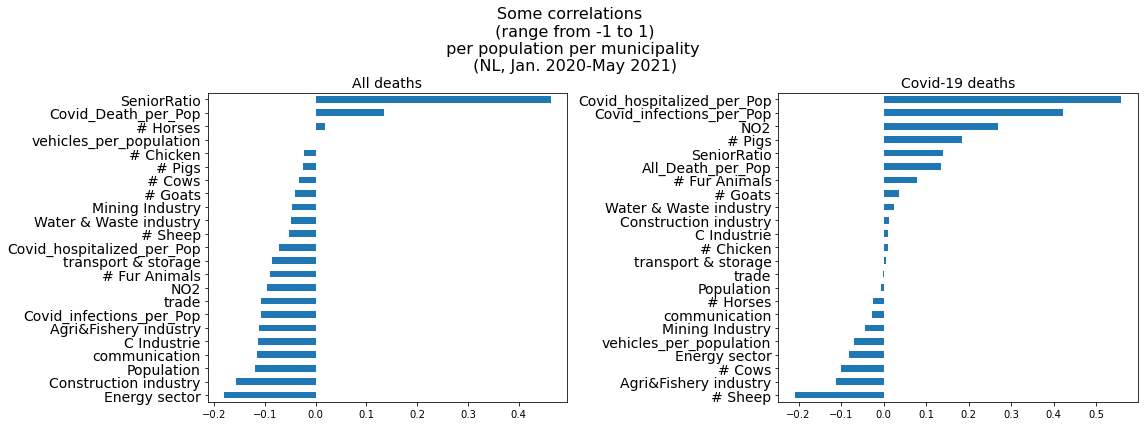

In [87]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('Some correlations \n (range from -1 to 1)\n per population per municipality \n (NL, Jan. 2020-May 2021)',fontsize = 16)
ax = plt.subplot(121)
plt.rcParams['figure.dpi'] = 500
plt.tick_params(axis='y', labelsize=14)
res0.plot.barh(rot=0)
plt.title('All deaths',fontsize = 14)

plt.subplot(122)
res1.plot.barh(rot=0)
plt.title('Covid-19 deaths',fontsize = 14)
plt.tick_params(axis='y', labelsize=14)

# plt.subplots_adjust(bottom=0.25, top=0.75)
plt.tight_layout()
plt.subplots_adjust(top=0.78)
plt.show()

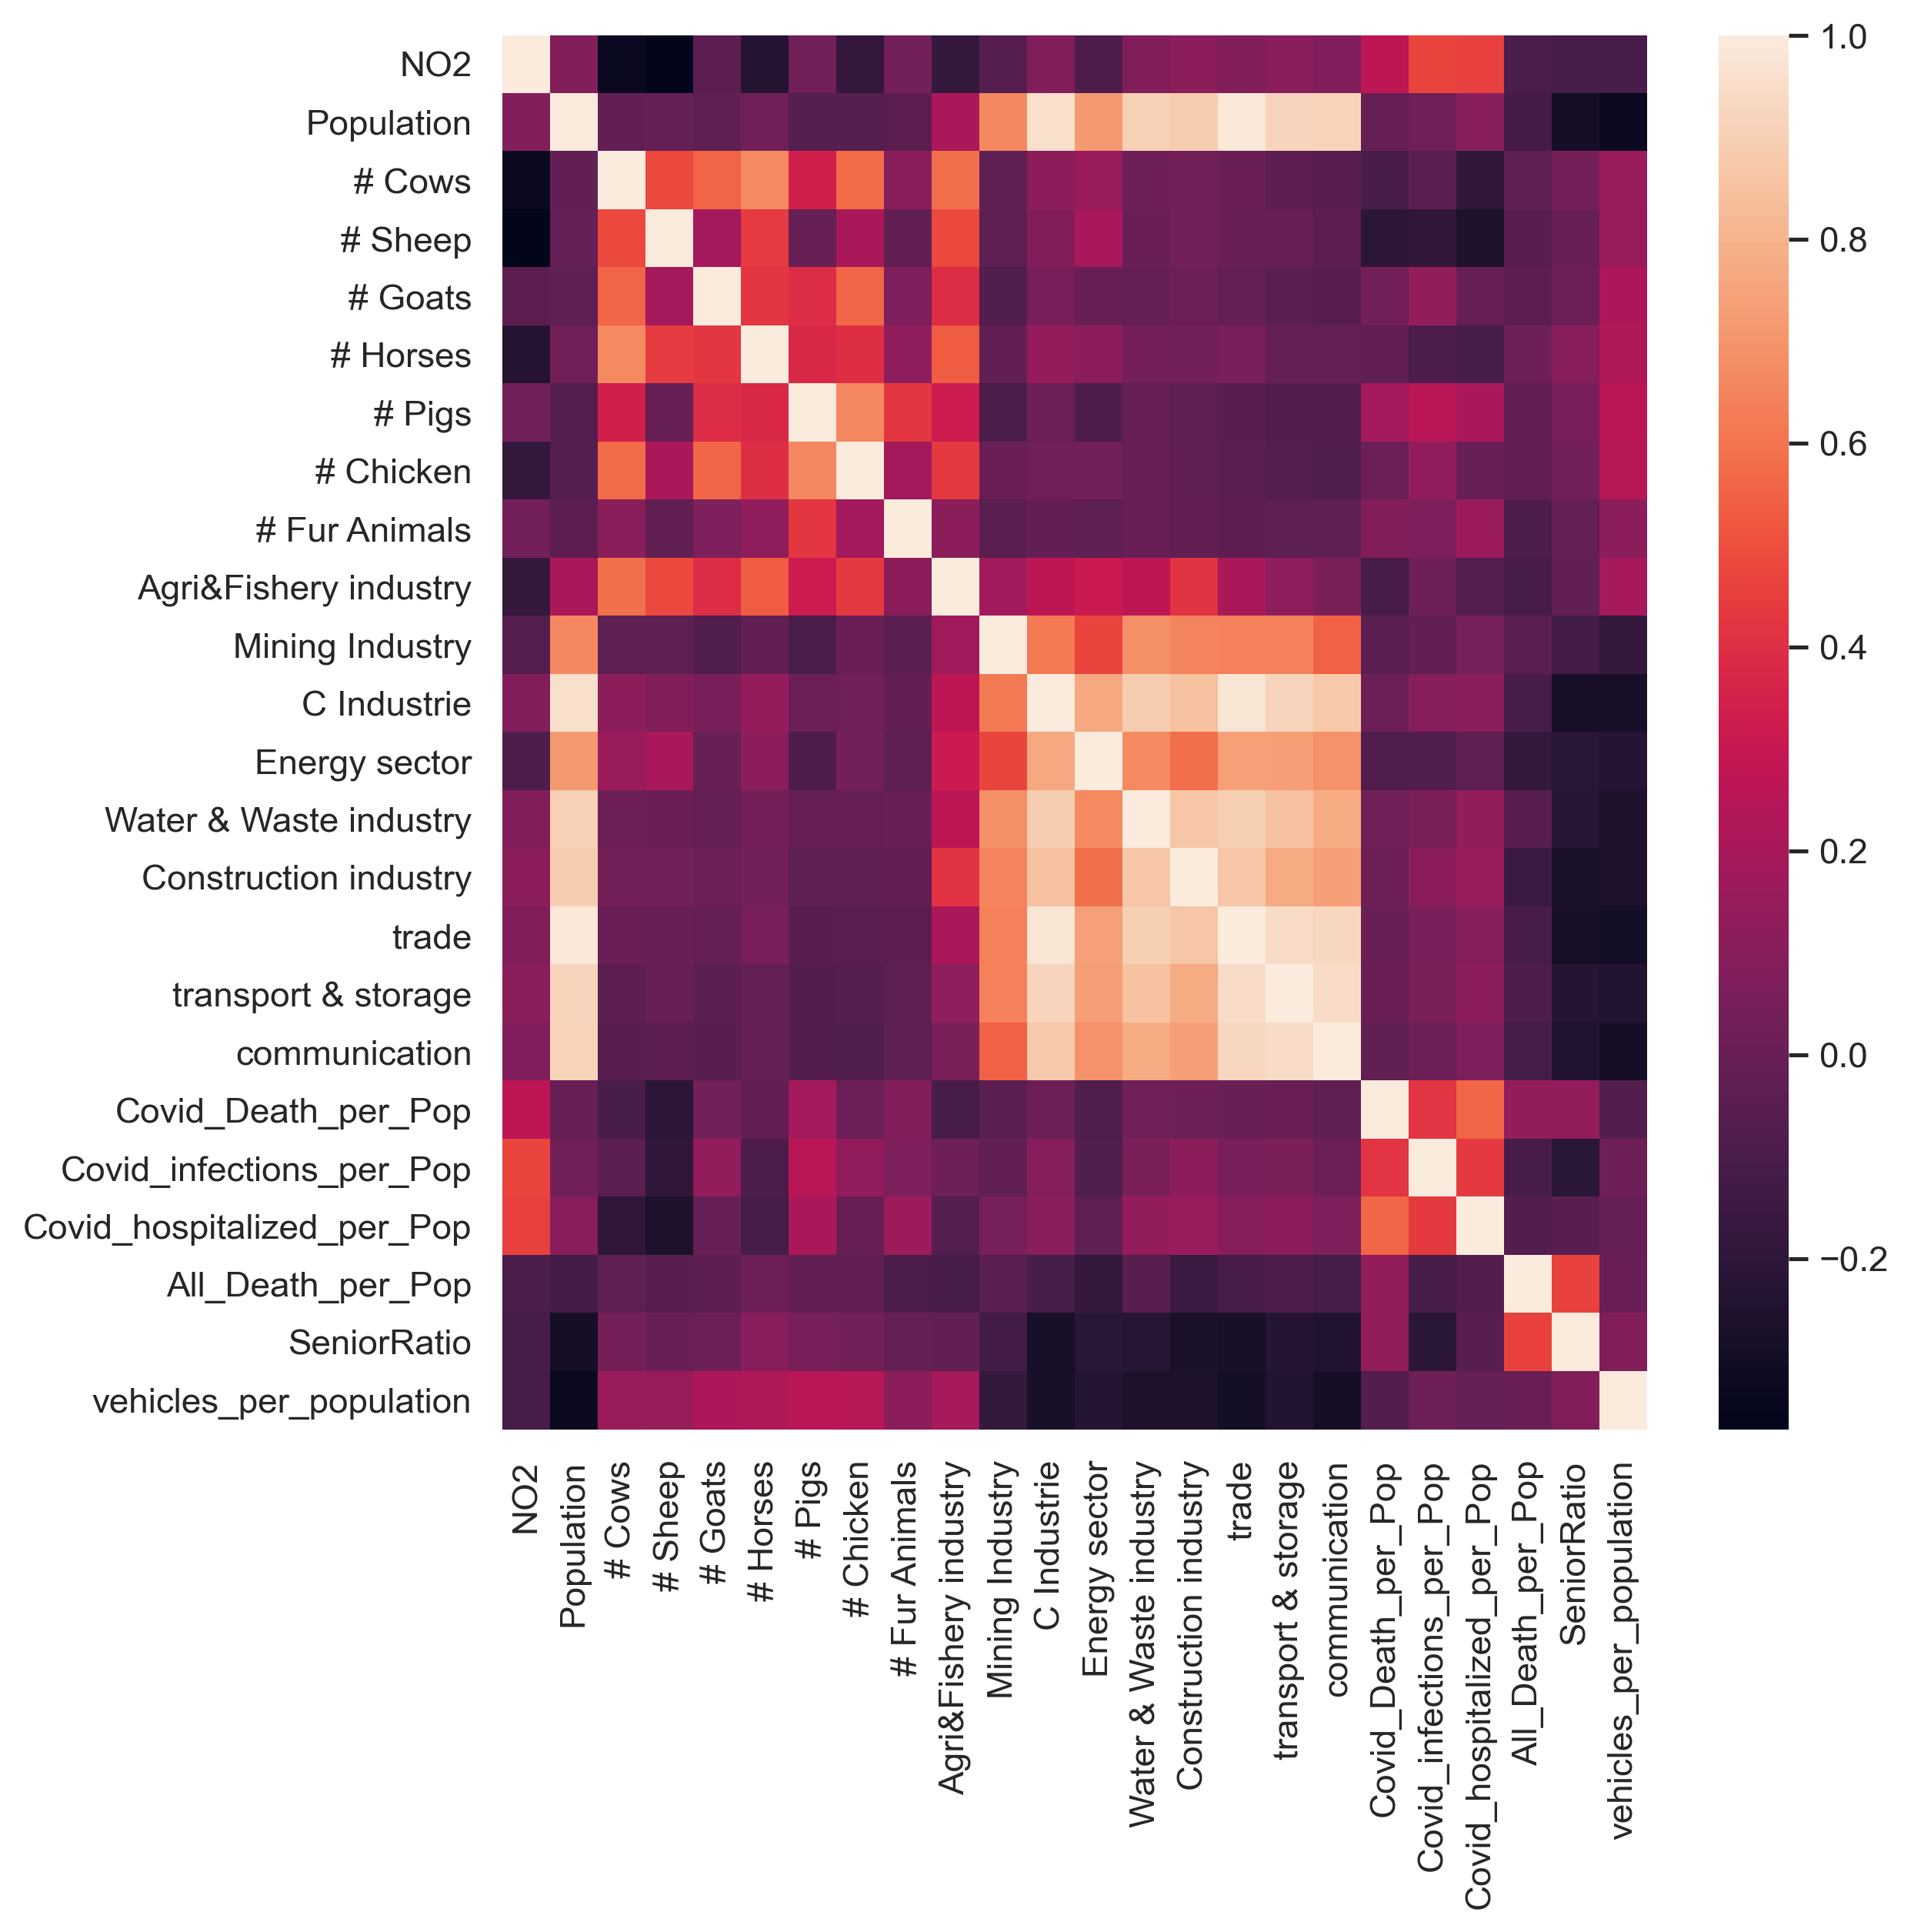

In [88]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
sns.set(rc={"figure.dpi":300})
sns.heatmap(numdata.corr(), xticklabels=True, yticklabels=True)

Let's compute partial correlation to reduce/remove the effect of confounding factors.

In [89]:
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr

    return P_corr


In [90]:
pc = partial_corr(numdata)

In [91]:
ticks = ['NO2', 'Population', '# Cows',
       '# Sheep', '# Goats', '# Horses', '# Pigs', '# Chicken',
       '# Fur Animals', 'Agri&Fishery industry', 'Mining Industry',
       'C Industrie', 'Energy sector', 'Water & Waste industry',
       'Construction industry', 'trade', 'transport & storage',
       'communication',  'Covid_Death_per_Pop','Covid_infections_per_Pop','Covid_hospitalized_per_Pop', 'All_Death_per_Pop',
       'SeniorRatio', 'vehicles_per_population']

In [92]:
pc_df = pd.DataFrame(columns = ticks ,index = ticks, data = pc)

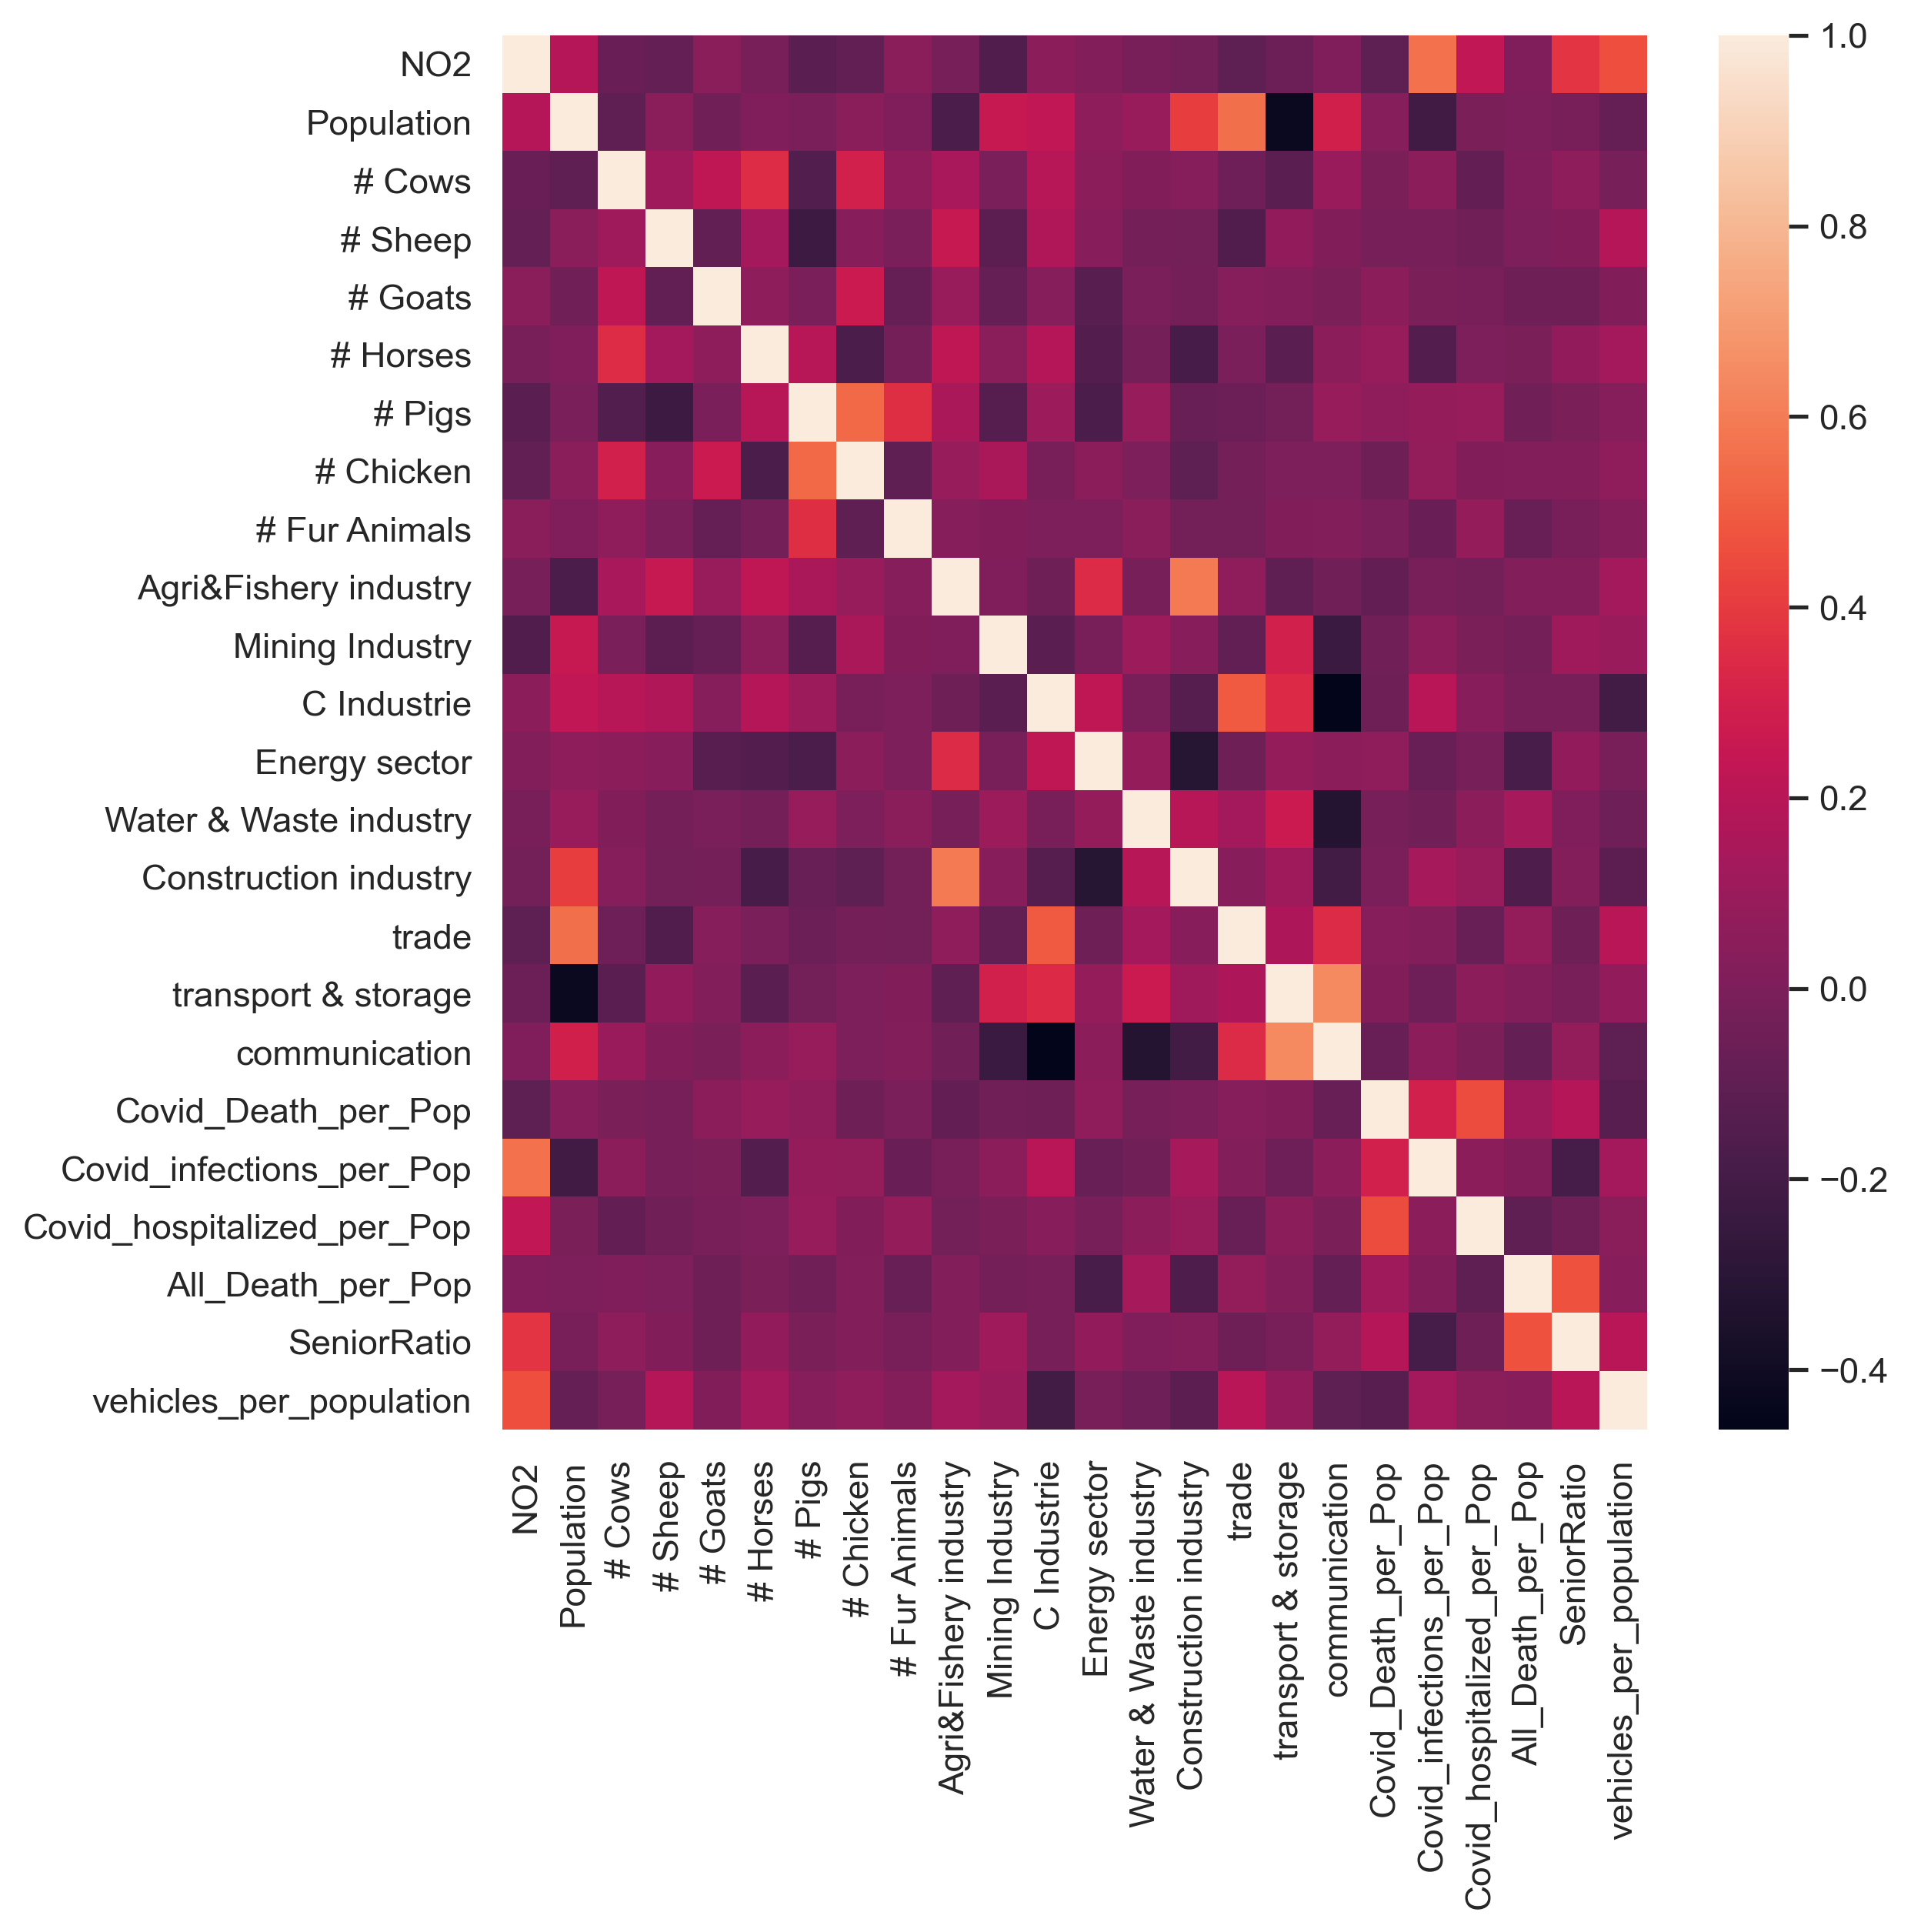

In [93]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
sns.set(rc={"figure.dpi":300})
sns.heatmap(pc_df, xticklabels=True, yticklabels=True)

we can do this also with recursive feature elimination

In [94]:
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.linear_model import LinearRegression

rankings = []
features = [x for x in ticks if x != 'Covid_Death_per_Pop']

X = df[features]
y = df['Covid_Death_per_Pop']

for i in range(1,len(ticks)):
    prd = LinearRegression()
    rfe = RFE(prd)#, n_features_to_select=1
    rfe.fit(X, y)
    rankings.append(rfe.ranking_)

In [95]:
feats = []
counts = []
for i, feat in enumerate(df[features]):
    feats.append(feat)
    count = 0
    for ranking in rankings:       
#         print(rankings)
        if ranking[i]==1:
            count+=1
    counts.append(count)        
            
           

the algorithm finds the following as relevant features

In [96]:
for i in range(len(feats)):
    if counts[i]>1:
        print(feats[i])

NO2
# Horses
Agri&Fishery industry
Mining Industry
Energy sector
Water & Waste industry
Covid_infections_per_Pop
Covid_hospitalized_per_Pop
All_Death_per_Pop
SeniorRatio
vehicles_per_population


By normalizing and binning the data, we can also use mutual information as measure of association.

In [97]:
ndf = (df[ticks]-df[ticks].min())/(df[ticks].max()-df[ticks].min())

In [98]:
ndf = ndf.applymap(lambda x: str(int(np.round(x*10))))

In [105]:
ndf.head()

NO2 Population # Cows # Sheep # Goats # Horses # Pigs # Chicken  \
0   9          0      1       0       0        1      1         0   
1   7          1      0       0       6        2      1         4   
2   7          0      1       0       0        2      0         0   
3   7          2      0       1       0        2      0         0   
4   6          1      0       0       0        0      0         0   

  # Fur Animals Agri&Fishery industry  ... Construction industry trade  \
0             0                     0  ...                     0     0   
1             0                     1  ...                     0     1   
2             0                     0  ...                     0     0   
3             0                     0  ...                     2     1   
4             0                     7  ...                     2     1   

  transport & storage communication Covid_Death_per_Pop  \
0                   0             0                   2   
1                   0             0                   5   
2                   0             0                   6   
3                   1             1                   4   
4                   1             0                   3   

  Covid_infections_per_Pop Covid_hospitalized_per_Pop All_Death_per_Pop  \
0                        5                          5                 4   
1                        6                          6                 7   
2                        4                          5                 6   
3                        4                          5                 6   
4                        6                          4                 5   

  SeniorRatio vehicles_per_population  
0           6                       5  
1           8                       5  
2           7                       5  
3           6                       4  
4           6                       5  

[5 rows x 24 columns]

In [100]:
X = ndf[features]
y = ndf['Covid_Death_per_Pop']

In [101]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [102]:
mi = mutual_info_classif(X, y)

The following are the highest MI scores

In [103]:
for item in mi:
    if item>0.05:
        i = mi.tolist().index(item)
        print(item)
        print(features[i])

0.08756037515440251
NO2
0.053393100733558185
transport & storage
0.08021922528055869
Covid_infections_per_Pop
0.17398427448797182
Covid_hospitalized_per_Pop


Conclusion: standard statistical algorithms find a consistent correlation between NO2 concentrations and Covid-deaths in NL on municipality level. To investigate actual causal correlation: more data, time series analysis and causal inference with marginal structural models would be necessary?